In [1]:
import os
os.chdir("..\..")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from fix_data import add_label_T
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
hcc_smarts_df_train = pd.read_csv("data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt", sep = " ")
mcf_smarts_df_train = pd.read_csv("data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt", sep= " ")

hcc_smarts_df_train = add_label_T(hcc_smarts_df_train)
mcf_smarts_df_train = add_label_T(mcf_smarts_df_train)

X1 = hcc_smarts_df_train.loc[:,hcc_smarts_df_train.columns!='label']
X2 = mcf_smarts_df_train.loc[:,mcf_smarts_df_train.columns!='label']
y = mcf_smarts_df_train["label"]

# Linear SVM

In [5]:
svm = LinearSVC()
cross = cross_val_score(svm, X2, y, scoring="accuracy", cv=10)
print(f"Final accuracy = {round((sum(cross) / 10) * 100, 4)}%")

Final accuracy = 97.0175%


# Hyperparameters

In [7]:
svm = LinearSVC()
p_grid = {'penalty': ['l1', 'l2'], 
          'loss':['squared_hinge', 'hinge'],
          "C": [0.00001, 0.0001, 0.001, 0.1 , 1, 10, 100, 1000, 10000],
          'dual': [True, False]
            }

gs_t = GridSearchCV(svm, param_grid = p_grid, cv=5, scoring= 'accuracy').fit(X2, y)
gs_t.best_params_

c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python3

{'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}

In [8]:
svm_res_t = pd.DataFrame(gs_t.cv_results_)[["param_C", "param_loss", "param_penalty", "param_dual", "mean_test_score", "rank_test_score"]]
svm_res_t.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_t.iloc[:,:]


,param_C,param_loss,param_penalty,param_dual,mean_test_score,rank_test_score
28,0.1,squared_hinge,l1,False,0.980163,1
17,0.001,squared_hinge,l2,True,0.978360,2
21,0.001,squared_hinge,l2,False,0.978360,2
27,0.1,hinge,l2,True,0.976741,4
19,0.001,hinge,l2,True,0.974938,5
...,...,...,...,...,...,...
63,1000,hinge,l2,False,NaN,37
64,10000,squared_hinge,l1,True,NaN,37
66,10000,hinge,l1,True,NaN,37
70,10000,hinge,l1,False,NaN,37


In [9]:
best_fit_true = {}
for i in [0.00001, 0.0001, 0.001, 0.1 , 1, 10, 100, 1000, 10000]:
    best_fit_true[f"{i}"] = max([svm_res_t.iloc[j,:].values for j in range(svm_res_t.shape[0]) if svm_res_t.iloc[j,0] == i], key= lambda x: x[4])[4]

best_fit_true

{'1e-05': 0.9428927602692685,
 '0.0001': 0.9681402248536205,
 '0.001': 0.9783595573478283,
 '0.1': 0.9801627155604372,
 '1': 0.971885643735018,
 '10': 0.9693423766498575,
 '100': 0.9693886408034228,
 '1000': 0.9693423873393568,
 '10000': 0.9692036590156574}

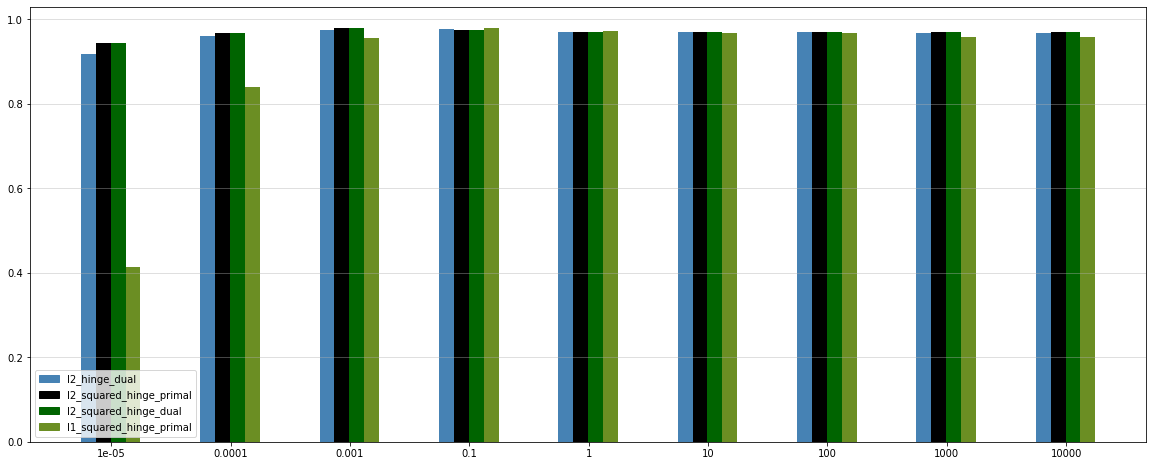

In [10]:
svm_res_t.sort_values(by="param_C", ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(20,8))


ax.bar([i for i in range(0,18,2)], [i for k,i in  enumerate(svm_res_t.loc[:,"mean_test_score"]) if (svm_res_t.iloc[k, 1] == "hinge" and svm_res_t.iloc[k, 2] == "l2" and svm_res_t.iloc[k, 3] == True)], width= 0.25, color= "steelblue")
ax.bar([i + 0.25 for i in range(0,18,2)], [i for k,i in  enumerate(svm_res_t.loc[:,"mean_test_score"]) if (svm_res_t.iloc[k, 1] == "squared_hinge" and svm_res_t.iloc[k, 2] == "l2" and svm_res_t.iloc[k, 3] == False)], width= 0.25, color= "black")
ax.bar([i + 0.25 + 0.25 for i in range(0,18,2)], [i for k,i in  enumerate(svm_res_t.loc[:,"mean_test_score"]) if (svm_res_t.iloc[k, 1] == "squared_hinge" and svm_res_t.iloc[k, 2] == "l2" and svm_res_t.iloc[k, 3] == True)], width= 0.25, color= "darkgreen")
ax.bar([i + 0.25 + 0.25 + 0.25 for i in range(0,18,2)], [i for k,i in  enumerate(svm_res_t.loc[:,"mean_test_score"]) if (svm_res_t.iloc[k, 1] == "squared_hinge" and svm_res_t.iloc[k, 2] == "l1" and svm_res_t.iloc[k, 3] == False)], width= 0.25, color= "olivedrab")

ax.set_xticks([i + 0.385 for i in range(0,18,2)], [0.00001, 0.0001, 0.001, 0.1 , 1, 10, 100, 1000, 10000])

ax.grid(axis= 'y', which= 'major', alpha=0.5)

colors = {"l2_hinge_dual": "steelblue", "l2_squared_hinge_primal": "black", "l2_squared_hinge_dual": "darkgreen", "l1_squared_hinge_primal": "olivedrab"}
label = list(colors.keys())
handle = [plt.Rectangle((0,0),2,2, color=colors[lab]) for lab in label]

ax.legend(handles= handle, labels= label, loc = "lower left")
plt.show() 

In [12]:
svm = LinearSVC(fit_intercept = False)
p_grid = {'penalty': ['l1', 'l2'], 
          'loss':['squared_hinge', 'hinge'],
          "C": [0.00001, 0.0001, 0.001, 0.1 , 1, 10, 100, 1000, 10000],
          'dual': [True, False]
            }

gs_f = GridSearchCV(svm, param_grid = p_grid, cv=5, scoring= 'accuracy').fit(X2, y)
gs_f.best_params_

c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python3

{'C': 0.001, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}

In [13]:
svm_res_f = pd.DataFrame(gs_f.cv_results_)[["param_C", "param_loss", "param_penalty", "param_dual", "mean_test_score", "rank_test_score"]]
svm_res_f.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_f.reset_index(drop= True)

,param_C,param_loss,param_penalty,param_dual,mean_test_score,rank_test_score
0,0.001,squared_hinge,l2,False,0.976556,1
1,0.001,squared_hinge,l2,True,0.976510,2
2,0.1,squared_hinge,l1,False,0.976464,3
3,0.1,hinge,l2,True,0.973597,4
4,0.001,hinge,l2,True,0.973458,5
...,...,...,...,...,...,...
67,1000,hinge,l2,False,NaN,37
68,10000,squared_hinge,l1,True,NaN,37
69,10000,hinge,l1,True,NaN,37
70,10000,hinge,l1,False,NaN,37


In [14]:
best_fit_false = {}
for i in [0.00001, 0.0001, 0.001, 0.1 , 1, 10, 100, 1000, 10000]:
    best_fit_false[f"{i}"] = max([svm_res_f.iloc[j,:].values for j in range(svm_res_f.shape[0]) if svm_res_f.iloc[j,0] == i], key= lambda x: x[4])[4]


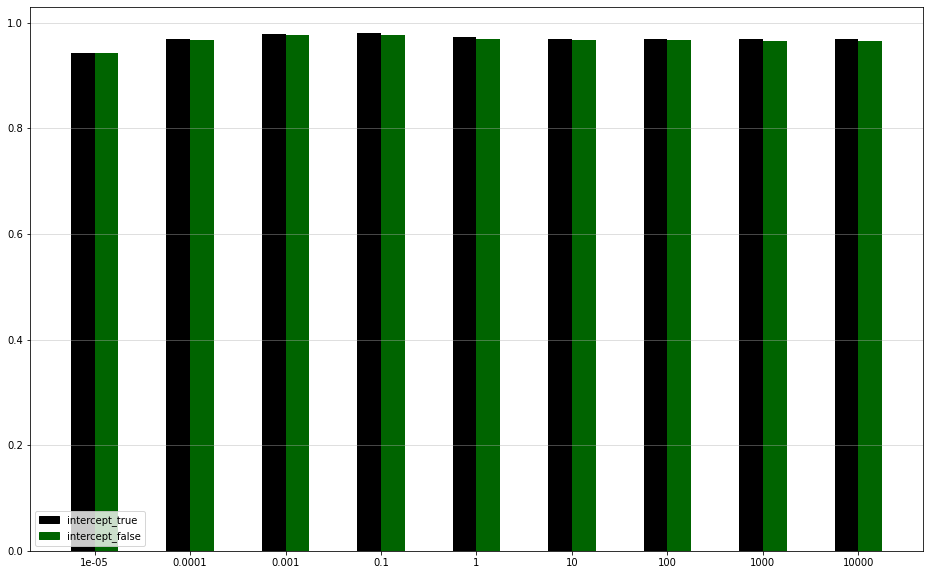

In [16]:
ig, ax = plt.subplots(figsize=(16,10))

ax.bar([i for i in range(9)], list(best_fit_true.values()), 0.25, color = "black")
ax.bar([i + 0.25 for i in range(9)], list(best_fit_false.values()), 0.25, color = "darkgreen")

ax.set_xticks([i + 0.125 for i in range(9)], [0.00001, 0.0001, 0.001, 0.1 , 1, 10, 100, 1000, 10000])
ax.grid(axis= 'y', which= 'major', alpha=0.5)

colors = {"intercept_true": "black", "intercept_false": "darkgreen"}
label = list(colors.keys())
handle = [plt.Rectangle((0,0),2,2, color=colors[lab]) for lab in label]

ax.legend(handles= handle, labels= label, loc = "lower left")
plt.show() 

In [18]:
svm = LinearSVC()
p_grid = {'penalty': ['l1', 'l2'], 
          'loss':['squared_hinge', 'hinge'],
          "C": [0.001, 0.1 , 1],
          'dual': [True, False],
          'fit_intercept': [True],
          'class_weight': ['balanced', None],
          'multi_class': ['ovr', 'crammer_singer']
            }

gs_cr = GridSearchCV(svm, param_grid = p_grid, cv=5, scoring= 'accuracy').fit(X2, y)
gs_cr.best_params_

c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python3

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'loss': 'squared_hinge',
 'multi_class': 'ovr',
 'penalty': 'l1'}

In [19]:
svm_res_cr = pd.DataFrame(gs_cr.cv_results_)[["param_C", "param_loss", "param_penalty", "param_dual", "param_multi_class", "param_class_weight", "mean_test_score", "rank_test_score"]]
svm_res_cr.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_cr.reset_index(drop= True, inplace=True)
svm_res_cr.iloc[:10,:]

,param_C,param_loss,param_penalty,param_dual,param_multi_class,param_class_weight,mean_test_score,rank_test_score
0,0.1,squared_hinge,l1,False,ovr,None,0.980163,1
1,0.1,squared_hinge,l1,False,ovr,balanced,0.979192,2
2,0.001,squared_hinge,l2,False,ovr,balanced,0.978544,3
3,0.001,squared_hinge,l2,True,ovr,balanced,0.978544,3
4,0.001,squared_hinge,l2,False,ovr,None,0.978360,5
5,0.001,squared_hinge,l2,True,ovr,None,0.978360,5
6,0.001,hinge,l1,True,crammer_singer,balanced,0.977943,7
7,0.001,squared_hinge,l1,True,crammer_singer,balanced,0.977943,7
8,0.001,squared_hinge,l2,True,crammer_singer,balanced,0.977943,7
9,0.001,squared_hinge,l1,False,crammer_singer,balanced,0.977943,7


In [21]:
svm = LinearSVC()
p_grid = {'penalty': ['l1'], 
          'loss':['squared_hinge'],
          "C": [0.1 , 1],
          'dual': [False],
          'fit_intercept': [True],
          'class_weight': ['balanced', None],
          'multi_class': ['ovr'],
          'intercept_scaling': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
            }

gsi = GridSearchCV(svm, param_grid = p_grid, cv=5, scoring= 'accuracy').fit(X2, y)
gsi.best_params_

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 10,
 'loss': 'squared_hinge',
 'multi_class': 'ovr',
 'penalty': 'l1'}

In [22]:
svm_res_i = pd.DataFrame(gsi.cv_results_)[["param_C", "param_loss", "param_penalty", "param_dual", "param_multi_class", "param_class_weight", "param_intercept_scaling", "mean_test_score", "rank_test_score"]]
svm_res_i.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_i.reset_index(drop= True, inplace=True)
svm_res_i.iloc[:,:]

,param_C,param_loss,param_penalty,param_dual,param_multi_class,param_class_weight,param_intercept_scaling,mean_test_score,rank_test_score
0,0.1,squared_hinge,l1,False,ovr,None,10,0.980348,1
1,0.1,squared_hinge,l1,False,ovr,None,1,0.980163,2
2,0.1,squared_hinge,l1,False,ovr,None,0.1,0.979423,3
3,0.1,squared_hinge,l1,False,ovr,balanced,1,0.979192,4
4,0.1,squared_hinge,l1,False,ovr,balanced,10,0.979099,5
5,0.1,squared_hinge,l1,False,ovr,balanced,0.1,0.978776,6
6,0.1,squared_hinge,l1,False,ovr,None,0.00001,0.976510,7
7,0.1,squared_hinge,l1,False,ovr,None,0.001,0.976510,7
8,0.1,squared_hinge,l1,False,ovr,None,0.0001,0.976464,9
9,0.1,squared_hinge,l1,False,ovr,None,0.01,0.976464,9


In [23]:
svm = LinearSVC()
p_grid = {'penalty': ['l1'], 
          'loss':['squared_hinge'],
          "C": [0.1 , 1],
          'dual': [False],
          'fit_intercept': [True],
          'class_weight': ['balanced', None],
          'multi_class': ['ovr'],
          'intercept_scaling': [10, 20, 30, 40, 50]
            }

gsi = GridSearchCV(svm, param_grid = p_grid, cv=5, scoring= 'accuracy').fit(X2, y)
gsi.best_params_

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 20,
 'loss': 'squared_hinge',
 'multi_class': 'ovr',
 'penalty': 'l1'}

In [24]:
svm_res_i = pd.DataFrame(gsi.cv_results_)[["param_C", "param_loss", "param_penalty", "param_dual", "param_multi_class", "param_class_weight", "param_intercept_scaling", "mean_test_score", "rank_test_score"]]
svm_res_i.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_i.reset_index(drop= True, inplace=True)
svm_res_i.iloc[:,:]

,param_C,param_loss,param_penalty,param_dual,param_multi_class,param_class_weight,param_intercept_scaling,mean_test_score,rank_test_score
0,0.1,squared_hinge,l1,False,ovr,None,20,0.980301,1
1,0.1,squared_hinge,l1,False,ovr,None,30,0.980301,1
2,0.1,squared_hinge,l1,False,ovr,None,40,0.980301,1
3,0.1,squared_hinge,l1,False,ovr,None,50,0.980301,1
4,0.1,squared_hinge,l1,False,ovr,None,10,0.980301,5
5,0.1,squared_hinge,l1,False,ovr,balanced,20,0.979145,6
6,0.1,squared_hinge,l1,False,ovr,balanced,30,0.979145,6
7,0.1,squared_hinge,l1,False,ovr,balanced,40,0.979145,6
8,0.1,squared_hinge,l1,False,ovr,balanced,50,0.979145,6
9,0.1,squared_hinge,l1,False,ovr,balanced,10,0.979099,10


In [25]:
svm = LinearSVC()
p_grid = {'penalty': ['l1'], 
          'loss':['squared_hinge'],
          "C": [0.1 , 1],
          'dual': [False],
          'fit_intercept': [True],
          'class_weight': ['balanced', None],
          'multi_class': ['ovr'],
          'intercept_scaling': [10, 11, 12, 13, 14, 15]
            }

gsi = GridSearchCV(svm, param_grid = p_grid, cv=5, scoring= 'accuracy').fit(X2, y)
gsi.best_params_

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 10,
 'loss': 'squared_hinge',
 'multi_class': 'ovr',
 'penalty': 'l1'}

In [26]:
svm_res_i = pd.DataFrame(gsi.cv_results_)[["param_C", "param_loss", "param_penalty", "param_dual", "param_multi_class", "param_class_weight", "param_intercept_scaling", "mean_test_score", "rank_test_score"]]
svm_res_i.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_i.reset_index(drop= True, inplace=True)
svm_res_i.iloc[:,:]

,param_C,param_loss,param_penalty,param_dual,param_multi_class,param_class_weight,param_intercept_scaling,mean_test_score,rank_test_score
0,0.1,squared_hinge,l1,False,ovr,None,12,0.980348,1
1,0.1,squared_hinge,l1,False,ovr,None,11,0.980348,1
2,0.1,squared_hinge,l1,False,ovr,None,13,0.980348,1
3,0.1,squared_hinge,l1,False,ovr,None,10,0.980348,1
4,0.1,squared_hinge,l1,False,ovr,None,15,0.980301,5
5,0.1,squared_hinge,l1,False,ovr,None,14,0.980301,5
6,0.1,squared_hinge,l1,False,ovr,balanced,11,0.979099,7
7,0.1,squared_hinge,l1,False,ovr,balanced,10,0.979099,7
8,0.1,squared_hinge,l1,False,ovr,balanced,15,0.979099,7
9,0.1,squared_hinge,l1,False,ovr,balanced,14,0.979099,7


In [30]:
svm = LinearSVC()
p_grid = {'penalty': ['l1'], 
          'loss':['squared_hinge'],
          "C": [0.1, 0.05, 0.15, 0.2, 0.3, 0.4],
          'dual': [False],
          'fit_intercept': [True],
          'class_weight': ['balanced', None],
          'multi_class': ['ovr'],
          'intercept_scaling': [1, 10],
          'max_iter': [10000]
            }

gsi = GridSearchCV(svm, param_grid = p_grid, cv=5, scoring= 'accuracy').fit(X2, y)
gsi.best_params_

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 10,
 'loss': 'squared_hinge',
 'max_iter': 10000,
 'multi_class': 'ovr',
 'penalty': 'l1'}

In [31]:
svm_res_i = pd.DataFrame(gsi.cv_results_)[["param_C", "param_loss", "param_penalty", "param_dual", "param_multi_class", "param_class_weight", "param_intercept_scaling", "mean_test_score", "rank_test_score"]]
svm_res_i.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_i.reset_index(drop= True, inplace=True)
svm_res_i.iloc[:,:]

,param_C,param_loss,param_penalty,param_dual,param_multi_class,param_class_weight,param_intercept_scaling,mean_test_score,rank_test_score
0,0.1,squared_hinge,l1,False,ovr,None,10,0.980348,1
1,0.1,squared_hinge,l1,False,ovr,None,1,0.980163,2
2,0.05,squared_hinge,l1,False,ovr,None,10,0.979885,3
3,0.05,squared_hinge,l1,False,ovr,None,1,0.979747,4
4,0.05,squared_hinge,l1,False,ovr,balanced,10,0.979284,5
5,0.1,squared_hinge,l1,False,ovr,balanced,1,0.979192,6
6,0.05,squared_hinge,l1,False,ovr,balanced,1,0.979099,7
7,0.1,squared_hinge,l1,False,ovr,balanced,10,0.979099,8
8,0.15,squared_hinge,l1,False,ovr,None,10,0.978591,9
9,0.15,squared_hinge,l1,False,ovr,None,1,0.978313,10


In [32]:
svm = LinearSVC()
p_grid = {'penalty': ['l1'], 
          'loss':['squared_hinge'],
          "C": [0.1, 0.06, 0.07, 0.08, 0.09],
          'dual': [False],
          'fit_intercept': [True],
          'class_weight': ['balanced', None],
          'multi_class': ['ovr'],
          'intercept_scaling': [10],
          'max_iter': [10000]
            }

gsi = GridSearchCV(svm, param_grid = p_grid, cv=5, scoring= 'accuracy').fit(X2, y)
gsi.best_params_

{'C': 0.08,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 10,
 'loss': 'squared_hinge',
 'max_iter': 10000,
 'multi_class': 'ovr',
 'penalty': 'l1'}

In [33]:
svm_res_i = pd.DataFrame(gsi.cv_results_)[["param_C", "param_loss", "param_penalty", "param_dual", "param_multi_class", "param_class_weight", "param_intercept_scaling", "mean_test_score", "rank_test_score"]]
svm_res_i.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_i.reset_index(drop= True, inplace=True)
svm_res_i.iloc[:,:]

,param_C,param_loss,param_penalty,param_dual,param_multi_class,param_class_weight,param_intercept_scaling,mean_test_score,rank_test_score
0,0.08,squared_hinge,l1,False,ovr,None,10,0.980301,1
1,0.1,squared_hinge,l1,False,ovr,None,10,0.980301,2
2,0.09,squared_hinge,l1,False,ovr,None,10,0.980209,3
3,0.07,squared_hinge,l1,False,ovr,None,10,0.979885,4
4,0.06,squared_hinge,l1,False,ovr,None,10,0.979885,5
5,0.08,squared_hinge,l1,False,ovr,balanced,10,0.979469,6
6,0.09,squared_hinge,l1,False,ovr,balanced,10,0.979423,7
7,0.06,squared_hinge,l1,False,ovr,balanced,10,0.979330,8
8,0.07,squared_hinge,l1,False,ovr,balanced,10,0.979238,9
9,0.1,squared_hinge,l1,False,ovr,balanced,10,0.979099,10


In [35]:
svm = LinearSVC(C=0.1, penalty= 'l1', dual=False, multi_class='ovr', class_weight=None, intercept_scaling= 10, max_iter= 10000)
cross = cross_val_score(svm, X2, y, scoring="accuracy", cv=10)
print(f"Final accuracy = {round((sum(cross) / 10) * 100, 4)}%")
print(cross)

Final accuracy = 98.0533%
[0.98104485 0.9801202  0.9778086  0.9778086  0.97503467 0.98335645
 0.98704903 0.97964847 0.98011101 0.98334875]


# Non linear SVM

In [37]:
nlsvm = SVC()
cross = cross_val_score(nlsvm, X2, y, scoring="accuracy", cv=10)
print(f"Final accuracy = {round((sum(cross) / 10) * 100, 4)}%")
print(cross)

Final accuracy = 98.1273%
[0.97827092 0.98196949 0.98335645 0.97965788 0.97364771 0.98566805
 0.98751156 0.98057354 0.98057354 0.98149861]


In [4]:
x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size=0.5)

In [6]:
nlsvm = SVC()
cross = cross_val_score(nlsvm, x_train, y_train, scoring="accuracy", cv=10)
print(f"Final accuracy = {round((sum(cross) / 10) * 100, 4)}%")
print(cross)

Final accuracy = 97.9932%
[0.974122   0.98336414 0.97781885 0.97964847 0.98334875 0.98149861
 0.98057354 0.97964847 0.98519889 0.97409806]


In [7]:
svm = SVC()
p_grid = {'kernel': ['poly', 'rbf', 'sigmoid'],
          "C": [0.001, 0.1 , 1, 10, 100],
            }

gsin = GridSearchCV(svm, param_grid = p_grid, cv=2, scoring= 'accuracy', verbose= True ).fit(x_train, y_train)
gsin.best_params_

Fitting 2 folds for each of 15 candidates, totalling 30 fits


{'C': 10, 'kernel': 'rbf'}

In [20]:
svm_res_n = pd.DataFrame(gsin.cv_results_)[["param_C", "param_kernel", "mean_test_score", "rank_test_score"]]
svm_res_n.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_n.reset_index(drop= True, inplace=True)
svm_res_n.iloc[:20,:]

,param_C,param_kernel,mean_test_score,rank_test_score
0,10,rbf,0.979839,1
1,100,rbf,0.979747,2
2,1,rbf,0.975678,3
3,100,poly,0.975030,4
4,10,poly,0.972810,5
5,0.1,rbf,0.955794,6
6,1,poly,0.951262,7
7,0.1,sigmoid,0.916675,8
8,0.1,poly,0.878849,9
9,1,sigmoid,0.848516,10


In [23]:
best_fit = {}
for i in [0.001, 0.1 , 1, 10, 100]:
    best_fit[f"{i}"] = max([svm_res_n.iloc[j,:].values for j in range(svm_res_n.shape[0]) if svm_res_n.iloc[j,0] == i], key= lambda x: x[2])[2]

best_fit

{'0.001': 0.6152776292443969,
 '0.1': 0.9557940368745493,
 '1': 0.9756775534051343,
 '10': 0.979839219257918,
 '100': 0.9797467465373705}

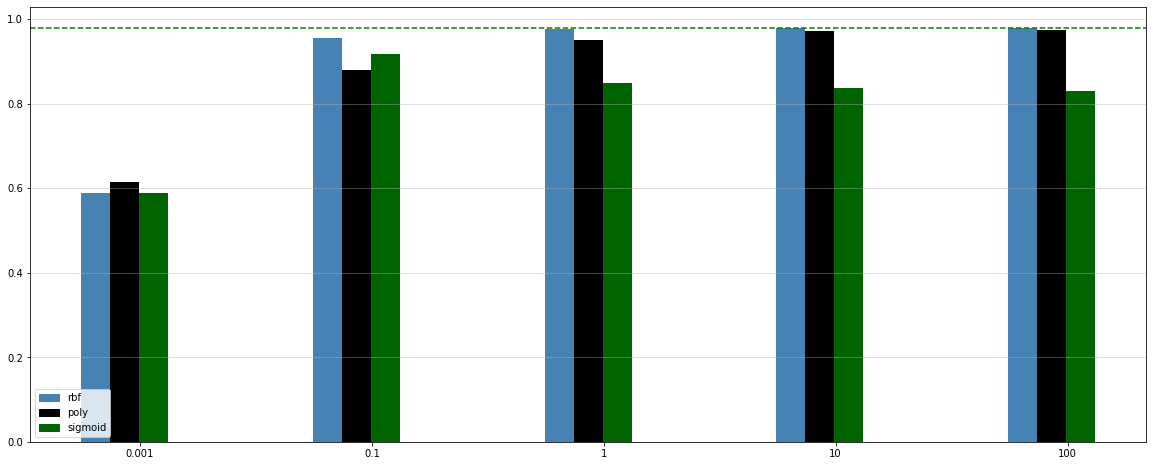

In [22]:
svm_res_n.sort_values(by="param_C", ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(20,8))

best = max(best_fit.values())

ax.bar([i for i in range(0,10,2)], [i for k,i in  enumerate(svm_res_n.loc[:,"mean_test_score"]) if svm_res_n.iloc[k, 1] == "rbf"], width= 0.25, color= "steelblue")
ax.bar([i + 0.25 for i in range(0,10,2)], [i for k,i in  enumerate(svm_res_n.loc[:,"mean_test_score"]) if svm_res_n.iloc[k, 1] == "poly"], width= 0.25, color= "black")
ax.bar([i + 0.25 + 0.25 for i in range(0,10,2)], [i for k,i in  enumerate(svm_res_n.loc[:,"mean_test_score"]) if svm_res_n.iloc[k, 1] == "sigmoid"], width= 0.25, color= "darkgreen")
ax.axhline(y=best, color='green', linestyle='--')

ax.set_xticks([i + 0.385 for i in range(0,10,2)], [0.001, 0.1 , 1, 10, 100])

ax.grid(axis= 'y', which= 'major', alpha=0.5)

colors = {"rbf": "steelblue", "poly": "black", "sigmoid": "darkgreen"}
label = list(colors.keys())
handle = [plt.Rectangle((0,0),2,2, color=colors[lab]) for lab in label]

ax.legend(handles= handle, labels= label, loc = "lower left")
plt.show() 

In [6]:
svm = SVC()
p_grid = {'kernel': ['poly'],
          "C": [1, 10, 100],
          "degree": [2, 4, 5]
            }

gsin = GridSearchCV(svm, param_grid = p_grid, cv=2, scoring= 'accuracy', verbose= True ).fit(x_train, y_train)
gsin.best_params_

Fitting 2 folds for each of 9 candidates, totalling 18 fits


{'C': 10, 'degree': 2, 'kernel': 'poly'}

In [7]:
svm_res_np = pd.DataFrame(gsin.cv_results_)[["param_C", "param_degree", "mean_test_score", "rank_test_score"]]
svm_res_np.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_np.reset_index(drop= True, inplace=True)
svm_res_np.iloc[:20,:]

,param_C,param_degree,mean_test_score,rank_test_score
0,10,2,0.977527,1
1,100,2,0.977157,2
2,1,2,0.971331,3
3,100,4,0.962360,4
4,10,4,0.950060,5
5,100,5,0.944048,6
6,10,5,0.917969,7
7,1,4,0.903357,8
8,1,5,0.860168,9


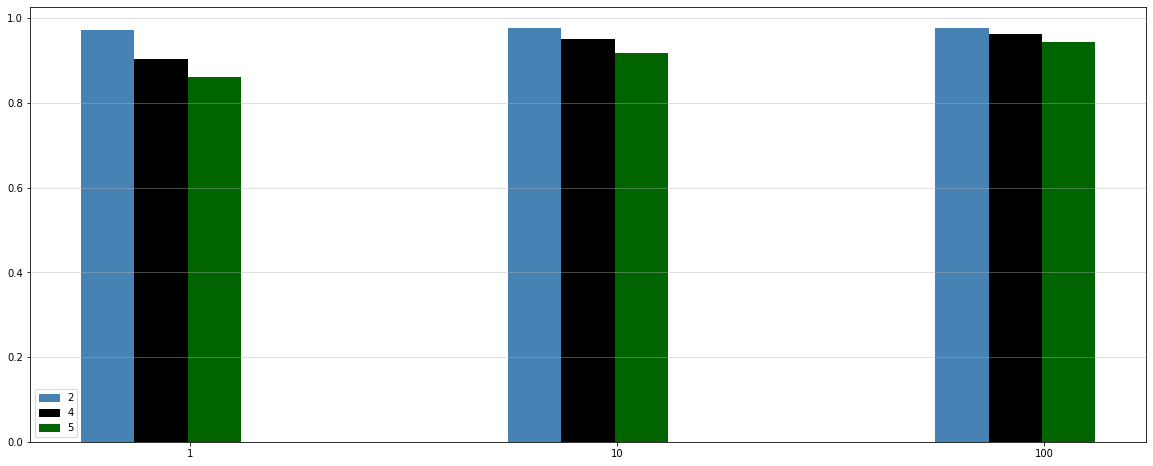

In [8]:
svm_res_np.sort_values(by="param_C", ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(20,8))

# best = max(best_fit.values())

ax.bar([i for i in range(0,6,2)], [i for k,i in  enumerate(svm_res_np.loc[:,"mean_test_score"]) if svm_res_np.iloc[k, 1] == 2], width= 0.25, color= "steelblue")
ax.bar([i + 0.25 for i in range(0,6,2)], [i for k,i in  enumerate(svm_res_np.loc[:,"mean_test_score"]) if svm_res_np.iloc[k, 1] == 4], width= 0.25, color= "black")
ax.bar([i + 0.25 + 0.25 for i in range(0,6,2)], [i for k,i in  enumerate(svm_res_np.loc[:,"mean_test_score"]) if svm_res_np.iloc[k, 1] == 5], width= 0.25, color= "darkgreen")
# ax.axhline(y=best, color='green', linestyle='--')

ax.set_xticks([i + 0.385 for i in range(0,6,2)], [1, 10, 100])

ax.grid(axis= 'y', which= 'major', alpha=0.5)

colors = {"2": "steelblue", "4": "black", "5": "darkgreen"}
label = list(colors.keys())
handle = [plt.Rectangle((0,0),2,2, color=colors[lab]) for lab in label]

ax.legend(handles= handle, labels= label, loc = "lower left")
plt.show() 

In [11]:
best_fit_d = {}
for i in [1, 10, 100]:
    best_fit_d[f"{i}"] = max([svm_res_np.iloc[j,:].values for j in range(svm_res_np.shape[0]) if svm_res_np.iloc[j,0] == i], key= lambda x: x[2])[2]

best_fit_d

{'1': 0.9713306513165372, '10': 0.9775267170213644, '100': 0.9771568432447463}

In [12]:
best_fit = [0.9756775534051343, 0.979839219257918, 0.9797467465373705]

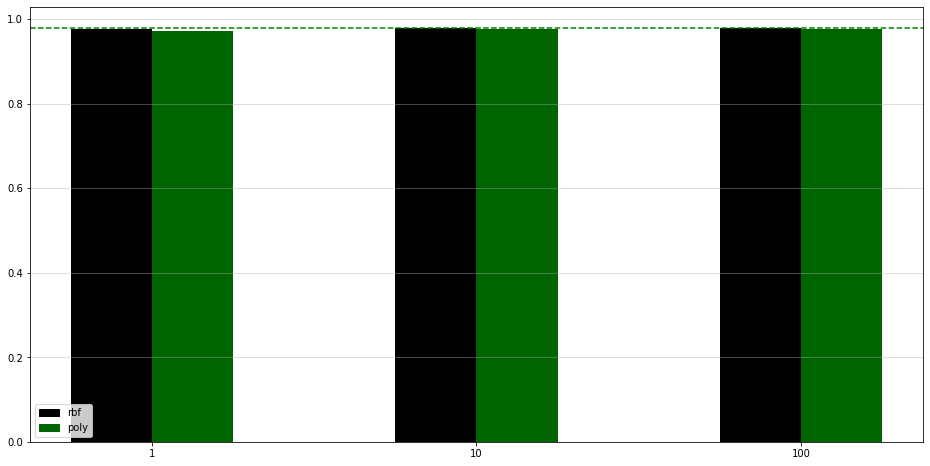

In [14]:
fig, ax = plt.subplots(figsize=(16,8))

ax.bar([i for i in range(3)], best_fit, 0.25, color = "black")
ax.bar([i + 0.25 for i in range(3)], list(best_fit_d.values()), 0.25, color = "darkgreen")

best = max([*[i for i in best_fit], *[i for i in best_fit_d.values()]])

ax.set_xticks([i + 0.125 for i in range(3)], [1, 10, 100])
ax.grid(axis= 'y', which= 'major', alpha=0.5)
ax.axhline(y=best, color='green', linestyle='--')

colors = {"rbf": "black", "poly": "darkgreen"}
label = list(colors.keys())
handle = [plt.Rectangle((0,0),2,2, color=colors[lab]) for lab in label]

ax.legend(handles= handle, labels= label, loc = "lower left")
plt.show() 

In [15]:
svm = SVC()
p_grid = {'kernel': ['poly', 'rbf'],
          "degree": [2],
          "C": [1, 10, 100],
          "gamma": ["scale", "auto"]
            }

gsin = GridSearchCV(svm, param_grid = p_grid, cv=2, scoring= 'accuracy', verbose= True ).fit(x_train, y_train)
gsin.best_params_

Fitting 2 folds for each of 12 candidates, totalling 24 fits


{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

In [16]:
svm_res_npg = pd.DataFrame(gsin.cv_results_)[["param_kernel", "param_C", "param_gamma", "mean_test_score", "rank_test_score"]]
svm_res_npg.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_npg.reset_index(drop= True, inplace=True)
svm_res_npg.iloc[:20,:]

,param_kernel,param_C,param_gamma,mean_test_score,rank_test_score
0,rbf,10,scale,0.977527,1
1,rbf,100,scale,0.977527,1
2,poly,10,scale,0.977527,3
3,poly,100,scale,0.977157,4
4,rbf,10,auto,0.975770,5
5,rbf,100,auto,0.973550,6
6,rbf,1,scale,0.972995,7
7,poly,1,scale,0.971331,8
8,poly,100,auto,0.970776,9
9,rbf,1,auto,0.965874,10


In [39]:
svm = SVC()
p_grid = {'kernel': ['rbf'],
          "C": [75000, 72500, 77500],
          "gamma": [0.0000001]
            }

gsin = GridSearchCV(svm, param_grid = p_grid, cv=2, scoring= 'accuracy', verbose= True ).fit(x_train, y_train)
gsin.best_params_

Fitting 2 folds for each of 3 candidates, totalling 6 fits


{'C': 72500, 'gamma': 1e-07, 'kernel': 'rbf'}

In [40]:
svm_res_npg = pd.DataFrame(gsin.cv_results_)[["param_kernel", "param_C", "param_gamma", "mean_test_score", "rank_test_score"]]
svm_res_npg.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_npg.reset_index(drop= True, inplace=True)
svm_res_npg.iloc[:,:]

,param_kernel,param_C,param_gamma,mean_test_score,rank_test_score
0,rbf,72500,0.0,0.979007,1
1,rbf,75000,0.0,0.979007,2
2,rbf,77500,0.0,0.979007,2


In [41]:
nlsvm = SVC(C= 72500, gamma= 0.0000001)
cross = cross_val_score(nlsvm, x_train, y_train, scoring="accuracy", cv=10)
print(f"Final accuracy = {round((sum(cross) / 10) * 100, 4)}%")
print(cross)

Final accuracy = 98.0301%
[0.97781885 0.98798521 0.98336414 0.98057354 0.9759482  0.98334875
 0.98057354 0.98334875 0.97502313 0.97502313]


In [42]:
nlsvm.fit(x_train,y_train)
y_hat = nlsvm.predict(x_test)
print("Accuracy =", accuracy_score(y_test, y_hat))

Accuracy = 0.9783593822250994


In [43]:
nlsvm = SVC(C= 72500, gamma= 0.0000001)
cross = cross_val_score(nlsvm, X2, y, scoring="accuracy", cv=10)
print(f"Final accuracy = {round((sum(cross) / 10) * 100, 4)}%")
print(cross)

# Final SVM

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size=0.2)

In [6]:
import tools
nlsvm = SVC(C= 72500, gamma= 0.0000001)
cross = cross_val_score(nlsvm, X2, y, scoring="accuracy", cv=10)
print(f"Final accuracy = {round((sum(cross) / 10) * 100, 4)}%")
print(cross)

nlsvm.fit(x_train, y_train)

print(tools.model_metrics(nlsvm, x_test, y_test))

Final accuracy = 98.0117%
[0.97965788 0.97873324 0.98104485 0.9778086  0.97272307 0.98289413
 0.98566142 0.98057354 0.9787234  0.98334875]


NameError: name 'svm' is not defined

In [7]:
import tools
nlsvm = SVC(C= 10)
cross = cross_val_score(nlsvm, X2, y, scoring="accuracy", cv=10)
print(f"Final accuracy = {round((sum(cross) / 10) * 100, 4)}%")
print(cross)

nlsvm.fit(x_train, y_train)

print(tools.model_metrics(nlsvm, x_test, y_test))

Final accuracy = 98.2105%
[0.98150717 0.98474341 0.98150717 0.97873324 0.97549699 0.98566805
 0.98704903 0.98334875 0.97826087 0.98473636]


NameError: name 'svm' is not defined

In [11]:
nlsvm = SVC(C= 72500, gamma= 0.0000001)
nlsvm.fit(x_train, y_train)
print(tools.model_metrics(nlsvm, x_test, y_test))

nlsvm = SVC(C= 10)
nlsvm.fit(x_train, y_train)
print(tools.model_metrics(nlsvm, x_test, y_test))

(0.9817383263985205, 0.983024082116068, 0.9857482185273159)
(0.9803513638465094, 0.9807010634107917, 0.9857482185273159)


In [12]:
svm = LinearSVC(C=0.1, penalty= 'l1', dual=False, multi_class='ovr', class_weight=None, intercept_scaling= 10, max_iter= 10000)
cross = cross_val_score(svm, X2, y, scoring="accuracy", cv=10)
print(f"Final accuracy = {round((sum(cross) / 10) * 100, 4)}%")
print(cross)

Final accuracy = 98.0533%
[0.98104485 0.9801202  0.9778086  0.9778086  0.97503467 0.98335645
 0.98704903 0.97964847 0.98011101 0.98334875]


In [13]:
svm = LinearSVC(C=0.1, penalty= 'l1', dual=False, multi_class='ovr', class_weight=None, intercept_scaling= 10, max_iter= 10000)
svm.fit(x_train, y_train)
print(tools.model_metrics(nlsvm, x_test, y_test))

(0.9803513638465094, 0.9807010634107917, 0.9857482185273159)
